# Dynamics

In [1]:
from cyecca import lie
import numpy as np
import casadi as ca
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
def group_dynamics(t, state, controls):
        # State should be 10x1 vector (p, v, q)
        # Create Lie group from state
        X_lie = lie.SE23Quat.elem(ca.DM(state))
        X = ca.DM(X_lie.to_Matrix())

        u = controls(t) if callable(controls) else controls
        a, omega = u[0:3], u[3:6]

        g = [0,0,-9.81]
        M = np.zeros([5,5])
        M[0:3, 3] = g
        C = np.zeros((5,5))
        C[3,4] = 1
        
        skew_omega = np.array([[0, -omega[2], omega[1]],
                                [omega[2], 0, -omega[0]],
                                [-omega[1], omega[0], 0]])
        N = np.zeros([5,5])
        N[0:3,0:3] = skew_omega
        N[0:3,3] = a

        X_dot = (M-C)@X + X@(N+C)

        # We now have our X_dot matrix, but need to extract parameters
        X_dot_lie = lie.SE23Quat.from_Matrix(ca.SX(X_dot))
        new_state = ca.DM(X_dot_lie.param).full().ravel()

        return new_state

In [3]:
def simulate_group_dynamics(t_span, state_0, controls,
                        rtol=1e-9, atol=1e-12):
    sol = solve_ivp(
        lambda t, x: group_dynamics(t, x, controls),
        (t_span[0], t_span[-1]), state_0,
        dense_output=True, rtol=rtol, atol=atol
    )
    return np.array([sol.sol(t) for t in t_span])

In [4]:
x0 = np.array([0,0,0,0,0,0,1,0,0,0])
t_span = np.linspace(0, 50, 500)
def controls(t):
    a_thrust = np.array([0, 0, 10.0]) 
    omega = np.array([0,0,0])
    return np.concatenate([a_thrust, omega])

res = simulate_group_dynamics(t_span, x0, controls)


In [5]:
res_euler = np.zeros((res.shape[0], 9))
res_euler[:, 0:6] = res[:, 0:6]
for i,itm in enumerate(res):
    q = itm[6:10]
    q = q / np.linalg.norm(q)
    q_lie = lie.SO3Quat.elem(ca.DM(q))
    phi = lie.SO3EulerB321.from_Quat(q_lie).param
    phi = ca.DM(phi).full()
    res_euler[i,6:9] =  phi.flatten()

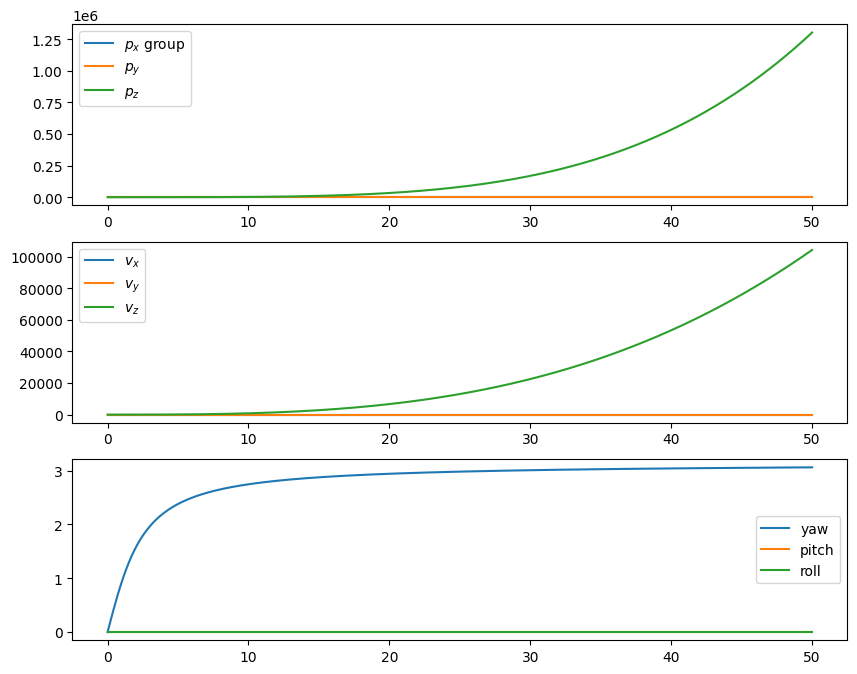

In [6]:
def plot_states(t_span, data_list, names):
    fig, ax = plt.subplots(3, 1, figsize=(10,8))
    for i,data in enumerate(data_list):
        ax[0].plot(t_span, data[:, 0], label=f'$p_x$ {names[i]}')
        ax[0].plot(t_span, data[:, 1], label=r'$p_y$')
        ax[0].plot(t_span, data[:, 2], label=r'$p_z$')
        ax[0].legend()

        ax[1].plot(t_span, data[:, 3], label=r'$v_x$')
        ax[1].plot(t_span, data[:, 4], label=r'$v_y$')
        ax[1].plot(t_span, data[:, 5], label=r'$v_z$')
        ax[1].legend()

        ax[2].plot(t_span, data[:, 6], label=r'yaw')
        ax[2].plot(t_span, data[:, 7], label=r'pitch')
        ax[2].plot(t_span, data[:, 8], label=r'roll')
        ax[2].legend()

    
    plt.plot()


plot_states(t_span, [res_euler], ["group"])

In [19]:
x0 = np.array([0,0,0,0,0,0,1,0,0,0])
def controls(t):
    a_thrust = np.array([0, 0, 10.0]) 
    omega = np.array([0,0,0])
    return np.concatenate([a_thrust, omega])

X_lie = lie.SE23Quat.elem(ca.DM(x0))
X = ca.DM(X_lie.to_Matrix())

u = controls(0) if callable(controls) else controls
a, omega = u[0:3], u[3:6]

g = [0,0,-9.81]
M = np.zeros([5,5])
M[0:3, 3] = g
C = np.zeros((5,5))
C[3,4] = 1

skew_omega = np.array([[0, -omega[2], omega[1]],
                        [omega[2], 0, -omega[0]],
                        [-omega[1], omega[0], 0]])
N = np.zeros([5,5])
N[0:3,0:3] = skew_omega
N[0:3,3] = a

X_dot = (M-C)@X + X@(N+C)
R = lie.SO3Quat.from_Matrix(ca.SX(X_dot[:3,:3]))
phi = R.param
lie.SO3EulerB321.elem(ca.DM(phi))
R2 = lie.SO3Quat.from_Euler()
quat = lie.SO3Quat.from_Euler(phi)
print(X_dot)
X_dot_lie = lie.SE23Quat.from_Matrix(ca.SX(X_dot))
X_dot_state = X_dot_lie.param
print(X_dot_state)

AssertionError: 

In [27]:
phi = [0,0,0]
phi_dm = ca.DM(phi)
phi_lie = lie.SO3EulerB321.elem(phi_dm)
R = lie.SO3Quat.from_Euler(phi_lie)
R.param

SX(@1=0, [1, @1, @1, @1])